<a href="https://colab.research.google.com/github/sholtodouglas/learning_from_play/blob/master/notebooks/train_lfp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install wandb -q
!pip install pathy -q

     |████████████████████████████████| 2.0MB 6.7MB/s 
     |████████████████████████████████| 163kB 23.9MB/s 
     |████████████████████████████████| 133kB 13.8MB/s 
     |████████████████████████████████| 102kB 9.8MB/s 
     |████████████████████████████████| 71kB 8.5MB/s 
     |████████████████████████████████| 122kB 9.5MB/s 


In [35]:
import argparse

parser = argparse.ArgumentParser(description='LFP training arguments')
parser.add_argument('run_name')
parser.add_argument('--train_datasets', nargs='+', help='Training dataset names')
parser.add_argument('--test_datasets', nargs='+', help='Testing dataset names')
parser.add_argument('-c', '--colab', default=False, action='store_true', help='Enable if using colab environment')
parser.add_argument('-s', '--data_source', default='LOCAL', help='Source of training data')
parser.add_argument('-tfr', '--from_tfrecords', default=False, action='store_true', help='Enable if using tfrecords format')
parser.add_argument('-d', '--device', default='CPU', help='Hardware device to train on')
parser.add_argument('-b', '--batch_size', default=32, type=int)
parser.add_argument('-la', '--actor_layer_size', default=256, type=int, help='Layer size of actor, increases size of neural net')
parser.add_argument('-le', '--encoder_layer_size', default=256, type=int, help='Layer size of encoder, increases size of neural net')
parser.add_argument('-lp', '--planner_layer_size', default=256, type=int, help='Layer size of planner, increases size of neural net')
parser.add_argument('-z', '--latent_dim', default=32, type=int, help='Size of the VAE latent space')
parser.add_argument('-g', '--gcbc', default=False, action='store_true', help='Enables GCBC, a simpler model with no encoder/planner')
parser.add_argument('-n', '--num_distribs', default=None, type=int, help='Number of distributions to use in logistic mixture model')
parser.add_argument('-q', '--qbits', default=None, type=int, help='Number of quantisation bits to discrete distributions into. Total quantisations = 2**qbits')
parser.add_argument('-lr', '--learning_rate', type=float, default=3e-4)
parser.add_argument('-t', '--train_steps', type=int, default=100000)
parser.add_argument('-r', '--resume', default=False, action='store_true')


# args = parser.parse_args()

### Sample local config
args = parser.parse_args('''
dummy_run 
--train_dataset UR5
--test_dataset UR5
-tfr
'''.split())

## Sample colab config
args = parser.parse_args('''
refactor_test
--train_dataset UR5 UR5_slow_gripper UR5_high_transition
--test_dataset UR5_slow_gripper_test
-c
-tfr
-s GCS
-d TPU
-b 512
-la 2048
-le 512
-lp 2048
-z 256
-lr 3e-4
'''.split())

## Sample colab config
args = parser.parse_args('''
single_opt_fully_in_line
--train_dataset UR5 UR5_slow_gripper UR5_high_transition
--test_dataset UR5_slow_gripper_test
-c
-s DRIVE
-d TPU
-b 512
-la 2048
-le 512
-lp 2048
-z 256
-lr 3e-4
'''.split())

print(args)

Namespace(actor_layer_size=2048, batch_size=512, colab=True, data_source='DRIVE', device='TPU', encoder_layer_size=512, from_tfrecords=False, gcbc=False, latent_dim=256, learning_rate=0.0003, num_distribs=None, planner_layer_size=2048, qbits=None, resume=False, run_name='single_opt_fully_in_line', test_datasets=['UR5_slow_gripper_test'], train_datasets=['UR5', 'UR5_slow_gripper', 'UR5_high_transition'], train_steps=100000)


In [3]:
from pathlib import Path
from pathy import Pathy
import os
import requests
import json
import pprint
import logging
import glob
import numpy as np
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
import random
import datetime
import time
import io
import wandb
from natsort import natsorted

pp = pprint.PrettyPrinter(indent=4)

wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [11]:
#@title Workpace Setup (Local vs Colab)

# Set up working directory and libraries
if args.colab:
    from google.colab import drive, auth
    print('Using colab setup')
    WORKING_PATH = Path('/content/learning_from_play')
    # Clone repo
    try:
        !git clone 'https://github.com/sholtodouglas/learning_from_play' {WORKING_PATH}
    except: 
        pass
    # Mount drive
    drive.mount('/content/drive')
else:
    print('Using local setup')
    WORKING_PATH = Path().absolute().parent
    print(f'Working path: {WORKING_PATH}')

# Change working directory to learning_from_play
os.chdir(WORKING_PATH)
import lfp
        
# Set up storage directory and datasets
if args.data_source == 'DRIVE':
    assert args.colab, "Must be using Colab"
    print('Reading data from Google Drive')
    STORAGE_PATH = Path('/content/drive/My Drive/Robotic Learning')
elif args.data_source == 'GCS':
    assert args.colab, "Must be using Colab"
    print('Reading data from Google Cloud Storage')
    r = requests.get('https://ipinfo.io')
    region = r.json()['region']
    if region != 'Iowa':
        logging.warning(f'You are accessing GCS data from {region}, outside of Iowa region')
    project_id = 'learning-from-play-303306'
    bucket_name = 'iowa_bucket_lfp'
    auth.authenticate_user()
    STORAGE_PATH = Pathy(f'gs://{bucket_name}')
else:
    print('Reading data from local filesystem')
    STORAGE_PATH = WORKING_PATH

print(f'Storage path: {STORAGE_PATH}')
TRAIN_DATA_PATHS = [STORAGE_PATH/'data'/x for x in args.train_datasets]
TEST_DATA_PATHS = [STORAGE_PATH/'data'/x for x in args.test_datasets]

Using colab setup
Cloning into '/content/learning_from_play'...
remote: Enumerating objects: 418, done.
remote: Counting objects: 100% (418/418), done.
remote: Compressing objects: 100% (282/282), done.
remote: Total 1682 (delta 281), reused 248 (delta 135), pack-reused 1264
Receiving objects: 100% (1682/1682), 60.68 MiB | 34.95 MiB/s, done.
Resolving deltas: 100% (923/923), done.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Reading data from Google Drive
Storage path: /content/drive/My Drive/Robotic Learning


# Data Creation

In [42]:
# Use this to edit modules without needing to restart the kernel
!git pull
import importlib
importlib.reload(lfp.data)
importlib.reload(lfp.model)
importlib.reload(lfp.plotting)
importlib.reload(lfp.train)


remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Total 4 (delta 3), reused 4 (delta 3), pack-reused 0
Unpacking objects: 100% (4/4), done.
From https://github.com/sholtodouglas/learning_from_play
   5473e48..bb18510  master     -> origin/master
Updating 5473e48..bb18510
Fast-forward
 lfp/train.py | 2 +-
 1 file changed, 1 insertion(+), 1 deletion(-)


<module 'lfp.train' from '/content/learning_from_play/lfp/train.py'>

In [43]:
print("Tensorflow version " + tf.__version__)

if args.device == 'TPU':
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
        print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
    except ValueError:
        raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)

    NUM_DEVICES = strategy.num_replicas_in_sync
    print("REPLICAS: ", NUM_DEVICES)
else:
    physical_devices = tf.config.list_physical_devices()
    if args.device == 'GPU':
        tf.config.experimental.set_memory_growth(physical_devices[3], enable=True)
    NUM_DEVICES = 1
    print(physical_devices)

Tensorflow version 2.4.1
Running on TPU  ['10.108.89.34:8470']


INFO:tensorflow:Initializing the TPU system: grpc://10.108.89.34:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.108.89.34:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


# Dataset

### Config Flags

In [44]:
GLOBAL_BATCH_SIZE = args.batch_size * NUM_DEVICES

dl = lfp.data.PlayDataloader(batch_size=GLOBAL_BATCH_SIZE)
dl.shuffle_size = GLOBAL_BATCH_SIZE * 1 # May need to be smaller with images - lets test

In [45]:
# Train data
train_data = dl.extract(TRAIN_DATA_PATHS, from_tfrecords=args.from_tfrecords)
train_dataset = dl.load(train_data)

UR5_high_transition: 100%|██████████| 32/32 [00:00<00:00, 58.79it/s]


{   'acts': TensorSpec(shape=(4096, 50, 7), dtype=tf.float32, name=None),
    'dataset_path': TensorSpec(shape=(4096, None, 1), dtype=tf.int32, name=None),
    'goals': TensorSpec(shape=(4096, 50, 11), dtype=tf.float32, name=None),
    'masks': TensorSpec(shape=(4096, 50), dtype=tf.float32, name=None),
    'obs': TensorSpec(shape=(4096, 50, 18), dtype=tf.float32, name=None),
    'seq_lens': TensorSpec(shape=(4096,), dtype=tf.float32, name=None),
    'tstep_idxs': TensorSpec(shape=(4096, None, 1), dtype=tf.int32, name=None)}


In [46]:
# Validation data
valid_data = dl.extract(TEST_DATA_PATHS, from_tfrecords=args.from_tfrecords)
valid_dataset = dl.load(valid_data)

UR5_slow_gripper_test: 100%|██████████| 2/2 [00:00<00:00, 46.48it/s]

{   'acts': TensorSpec(shape=(4096, 50, 7), dtype=tf.float32, name=None),
    'dataset_path': TensorSpec(shape=(4096, None, 1), dtype=tf.int32, name=None),
    'goals': TensorSpec(shape=(4096, 50, 11), dtype=tf.float32, name=None),
    'masks': TensorSpec(shape=(4096, 50), dtype=tf.float32, name=None),
    'obs': TensorSpec(shape=(4096, 50, 18), dtype=tf.float32, name=None),
    'seq_lens': TensorSpec(shape=(4096,), dtype=tf.float32, name=None),
    'tstep_idxs': TensorSpec(shape=(4096, None, 1), dtype=tf.int32, name=None)}


# Model

# Training Loop

In [47]:
def train_setup():
    model_params = {'obs_dim':dl.obs_dim,
                    'goal_dim':dl.goal_dim,
                    'act_dim':dl.act_dim,
                    'latent_dim':args.latent_dim}
    
    actor = lfp.model.create_actor(**model_params, layer_size=args.actor_layer_size, gcbc=args.gcbc, num_distribs=args.num_distribs)

    if args.gcbc:
        encoder = None
        planner = None
    else:
        encoder = lfp.model.create_encoder(layer_size=args.encoder_layer_size,**model_params)
        planner = lfp.model.create_planner(layer_size=args.planner_layer_size,**model_params)
        
    trainer = lfp.train.LFPTrainer(dl, 
                                 actor,
                                 encoder=encoder, 
                                 planner=planner, 
                                 probabilistic=args.num_distribs is not None,
                                 distribute_strategy=strategy,
                                 learning_rate=args.learning_rate,
                                 clipnorm=1.0,
                                 gcbc=args.gcbc)
    
    return trainer

if args.device=='GPU' or args.device == 'CPU':
    trainer = train_setup()
    train_dataset = iter(train_dataset)
    valid_dataset = iter(valid_dataset)
    plotting_dataset = valid_dataset # For consistnecy with the distributed form 
else:
    with strategy.scope():
        trainer = train_setup()   
    train_dataset = iter(strategy.experimental_distribute_dataset(train_dataset))
    plotting_dataset = iter(valid_dataset) # for the cluster fig, easier with a non distributed dataset
    valid_dataset = iter(strategy.experimental_distribute_dataset(valid_dataset))

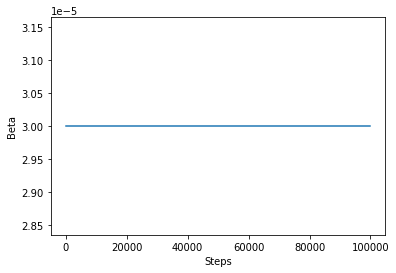

In [48]:
# 0.00001 so far works best for MAE - try lower - 0.00003 with a BETA accel of 10 so far works best, perfect encoder, nicely mapped planner
# recall 0.01 worked okay for probabilistic - proba still too unstable!
beta_sched = lfp.train.BetaScheduler('linear', 
                                   beta=0.00003, 
                                   beta_max=0.00003, 
                                   max_steps=args.train_steps, 
                                   cycles=90, 
                                   duty_cycle=0.5)

In [49]:
progbar = tf.keras.utils.Progbar(args.train_steps, verbose=1, interval=0.5)
best_valid_loss = np.float('inf')

valid_inc = 20
save_inc = 1000

prev_global_grad_norm = np.float('inf')

In [36]:
model_path = f'/content/drive/My Drive/Robotic Learning/saved_models/{args.run_name}/'

if args.resume:
    with open(model_path+'/config.json') as json_file:
        data = json.load(json_file)
        wandb.init(project="learning-from-play_v2", id=data['run_id'], resume="must")
        trainer.load_weights(model_path, with_optimizer=True)
        print('Loaded model weights and optimiser state')
        t = wandb.run.step + valid_inc
else:
    wandb.init(project="learning-from-play_v2", config=args)
    wandb.run.name = args.run_name
    t = 0

In [50]:
from lfp.metric import log # gets state and clears simultaneously

In [ ]:
while t < args.train_steps:
    start_time = time.time()
    beta = beta_sched.scheduler(t)
    x = next(train_dataset)
    total_train_loss = trainer.distributed_train_step(x, beta, prev_global_grad_norm)
    prev_global_grad_norm = log(trainer.metrics['global_grad_norm'])

    if t % valid_inc == 0:  
        valid_x = next(valid_dataset)
        if args.gcbc:
            total_val_loss= trainer.distributed_test_step(valid_x, beta)
        else:
            total_val_loss, ze, zp = trainer.distributed_test_step(valid_x, beta)

        metrics = {metric_name: log(metric) for metric_name, metric in trainer.metrics.items()}

        # validation plotting
        progbar.add(valid_inc, [('Train Loss', metrics['train_loss']), 
                                ('Validation Loss', metrics['valid_loss']), 
                                ('Time (s)', round(time.time() - start_time, 1))])

        wandb.log(metrics, step=t)
          
    if t % save_inc == 0:
        trainer.save_weights(model_path, args, wandb.run.id)
        if not args.gcbc:
            z_enc, z_plan = lfp.plotting.produce_cluster_fig(next(plotting_dataset), trainer.encoder, trainer.planner, TEST_DATA_PATHS[0], num_take=dl.batch_size//4)
            convergence_plot = lfp.plotting.project_enc_and_plan(ze, zp)
            wandb.log({'z_enc':z_enc, 'z_plan':z_plan, 'convergence_plot':convergence_plot}, step=t)
    t += 1

    20/100000 [..............................] - ETA: 255:54:20 - Train Loss: 0.0303 - Validation Loss: 0.0292 - Time (s): 28.5000Saving training config...


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/usr/local/lib/python3.6/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you me

    40/100000 [..............................] - ETA: 172:28:48 - Train Loss: 0.0278 - Validation Loss: 0.0243 - Time (s): 15.6500

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:474: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates



   140/100000 [..............................] - ETA: 85:29:32 - Train Loss: 0.0159 - Validation Loss: 0.0163 - Time (s): 6.4857